# Q-Learning: CartPole

### Import Libraries

In [1]:
%matplotlib notebook
# %matplotlib inline
import gym

import time
from pyglet.window import key

import numpy as np
import matplotlib.pyplot as plt

### Load Environment

In [2]:
env = gym.make("CartPole-v1")

### Play random

In [3]:
# env.reset()

# n_step = 0

# for _ in range(100):
#     env.render()
#     action = env.action_space.sample()
#     obs, rew, done, info = env.step(action)
#     time.sleep(0.1)
    
#     n_step += 1
    
#     if done:
#         env.reset()
#         print(f"Resettato dopo n.{n_step} step.")
#         n_step = 0
        
# env.close()

### Observations

* Cart Position (-4.8, 4.8)
* Cart Velocity $(-\infty \text{ to } +\infty)$
* Pole Angle (-0.418 to +0.418)
* Pole Angular Velocity  $(-\infty \text{ to } +\infty)$

### Actions

* 0 - Move to the left
* 1 - Move to the right

### How to play manually

In [4]:
# action = 0
# k = 0

# def key_press(k, mod):
    
#     """
#     Get the key press for gym
#     """
    
#     global action
#     if k == key.LEFT:
#         action = 0
#     if k == key.RIGHT:
#         action = 1
        

# env.reset()
# rewards = 0

# for _ in range(1000):    
#     env.render()
#     env.viewer.window.on_key_press = key_press
    
#     observation, reward, done, info = env.step(action)
    
#     rewards += 1
    
#     if done:
#         print(f"Punteggio raggiunto {rewards}")
#         break
    
#     time.sleep(0.5)
    
# env.close()

### Discretization Q-Table

The environment returns continuous values, but Q Table needs discrete states. How to solve? Discretize the observations.

Cart Velocity and Pole Angular Velocity have got infinite values... We need collect observations to get min and max values (indexes 1 and 3).

##### Same random observation

In [5]:
cart_velocity = []
pole_angular_velocity = []

observation = env.reset()

for episode in range(100000):
#     print(observation) # Rappresenta il numero di cella in cui si trova
#     env.render()
#     time.sleep(0.2)
#     clear_output(wait=True)
    
    action = env.action_space.sample() # Scelta casuale di una action
    
#     print(f'Observation: {observation} -> Action: {action}')
    
    observation, reward, done, info = env.step(action) # Esecuzione della scelta
    
    cart_velocity.append(observation[1])
    pole_angular_velocity.append(observation[3])
    
    if done:
        env.reset()
    
env.close()

In [6]:
global cart_velocity 
cart_velocity = np.array(cart_velocity)
print(f"Min and Max for cart_velocity: {cart_velocity.min():.02f} / {cart_velocity.max():.02f}")

Min and Max for cart_velocity: -2.80 / 2.79


In [7]:
global pole_angular_velocity 
pole_angular_velocity = np.array(pole_angular_velocity)
print(f"Min and Max for pole_angular_velocity: {pole_angular_velocity.min():.02f} / {pole_angular_velocity.max():.02f}")

Min and Max for pole_angular_velocity: -3.41 / 3.58


### Function to make discretization

In [8]:
def create_bins(n_bins_for_action=10):
    bins_cart_position = np.linspace(-4.8, 4.8, n_bins_for_action)
    bins_cart_velocity = np.linspace(cart_velocity.min()*2, cart_velocity.max()*2, n_bins_for_action)
    bins_pole_angle = np.linspace(-.418, .418, n_bins_for_action)
    bins_pole_anglular_velocity = np.linspace(pole_angular_velocity.min()*2, pole_angular_velocity.max()*2, n_bins_for_action)
    
    bins = np.array([bins_cart_position,
                    bins_cart_velocity,
                    bins_pole_angle,
                    bins_pole_anglular_velocity])
    
    return bins

In [9]:
NUM_BINS = 10
BINS = create_bins(NUM_BINS)

### Mapping for discretization

In [10]:
def discretize_observation(observations, bins):
    binned_observations = []
    
    for i, observation in enumerate(observations):
        discretized_observation = np.digitize(observation, bins[i])
        binned_observations.append(discretized_observation)
        
    return tuple(binned_observations)

In [11]:
observation = env.reset()

print(f"Original: {observation}")

mapped_observation = discretize_observation(observation, BINS)

print(f"Mapped: {mapped_observation}")

Original: [ 0.0227217  -0.00194599  0.0336777   0.00226237]
Mapped: (5, 5, 5, 5)


### Creating the Q-Learning Table

In [12]:
env.observation_space.shape

(4,)

In [13]:
q_table_shape = (NUM_BINS, NUM_BINS, NUM_BINS, NUM_BINS, env.action_space.n)
q_table = np.zeros(q_table_shape)

print(q_table.shape)

(10, 10, 10, 10, 2)


In [14]:
q_table

array([[[[[0., 0.],
          [0., 0.],
          [0., 0.],
          ...,
          [0., 0.],
          [0., 0.],
          [0., 0.]],

         [[0., 0.],
          [0., 0.],
          [0., 0.],
          ...,
          [0., 0.],
          [0., 0.],
          [0., 0.]],

         [[0., 0.],
          [0., 0.],
          [0., 0.],
          ...,
          [0., 0.],
          [0., 0.],
          [0., 0.]],

         ...,

         [[0., 0.],
          [0., 0.],
          [0., 0.],
          ...,
          [0., 0.],
          [0., 0.],
          [0., 0.]],

         [[0., 0.],
          [0., 0.],
          [0., 0.],
          ...,
          [0., 0.],
          [0., 0.],
          [0., 0.]],

         [[0., 0.],
          [0., 0.],
          [0., 0.],
          ...,
          [0., 0.],
          [0., 0.],
          [0., 0.]]],


        [[[0., 0.],
          [0., 0.],
          [0., 0.],
          ...,
          [0., 0.],
          [0., 0.],
          [0., 0.]],

         [[0., 0.],
    

### Hyperparameters

Nella scelta degli iper-parametri è buona norma partire dai valori da pubblicazioni oppure tramite propri esperimenti.

In [15]:
EPOCHS = 20000  # 5000
ALPHA = 0.8     # Leargning rate
GAMMA = 0.95    # Discount rate
# MAX_EPISODE = 100

##### Exploiration vs Exploitation parameters

Ad ogni epoca diminuisce il valore di epsilon secondo una funzione (lineare, esponenziale, ...) definita dall'utente. Il valore di epsilon, confrontato con un valore casuale (0-1), determinerà la scelta tra azione casuale oppure azione appresa dall'esperienza.

In [16]:
BURN_IN = 1
epsilon = 1.0

max_epsilon = 1.0
min_epsilon = 0.01     # Minima probabilità di esplorazione tramite scelte casuali
decay_rate = 0.0001    # 0.001

EPSILON_END = 10000
EPSILON_REDUCE = 0.0001

### Q-Table Update Functions

In [17]:
def epsilon_greedy_action_selection(epsilon, q_table, discrete_state):
    
    """
    L'exploitation usa il valore migliore della combinazione Q(s,a)
    """
    
    random_number = np.random.random()
    
    if random_number > epsilon:                     # Scelta dell'azione appresa
        action = np.argmax(q_table[discrete_state]) # Restituisce l'indice con il valore maggiore
    
    else:
        action = np.random.randint(0, env.action_space.n)
    
    return action

In [18]:
def compute_next_q_value(old_q_value, reward, next_optimal_q_value):
    
    """
    Funzione di aggiornamento dell'apprendimento per rinforzo...
    """
    
    return old_q_value + ALPHA * (reward + GAMMA * next_optimal_q_value - old_q_value)

In [19]:
def reduce_epsilon(epsilon, epoch):
    
    if BURN_IN <= epoch <= EPSILON_END:
        epsilon -= EPSILON_REDUCE
    
    return epsilon

### Custom Reward Values

In [20]:
def fail(done, points, reward):
    if done and points < 150:
        reward = -200
    return reward

### Agent training

In [21]:
q_table_shape = (NUM_BINS, NUM_BINS, NUM_BINS, NUM_BINS, env.action_space.n)
q_table = np.zeros(q_table_shape)

print(q_table.shape)

(10, 10, 10, 10, 2)


In [22]:
BURN_IN = 1
epsilon = 1.0

max_epsilon = 1.0
min_epsilon = 0.01     # Minima probabilità di esplorazione tramite scelte casuali
decay_rate = 0.0001    # 0.001

EPSILON_END = 10000
EPSILON_REDUCE = 0.0001

<IPython.core.display.Javascript object>


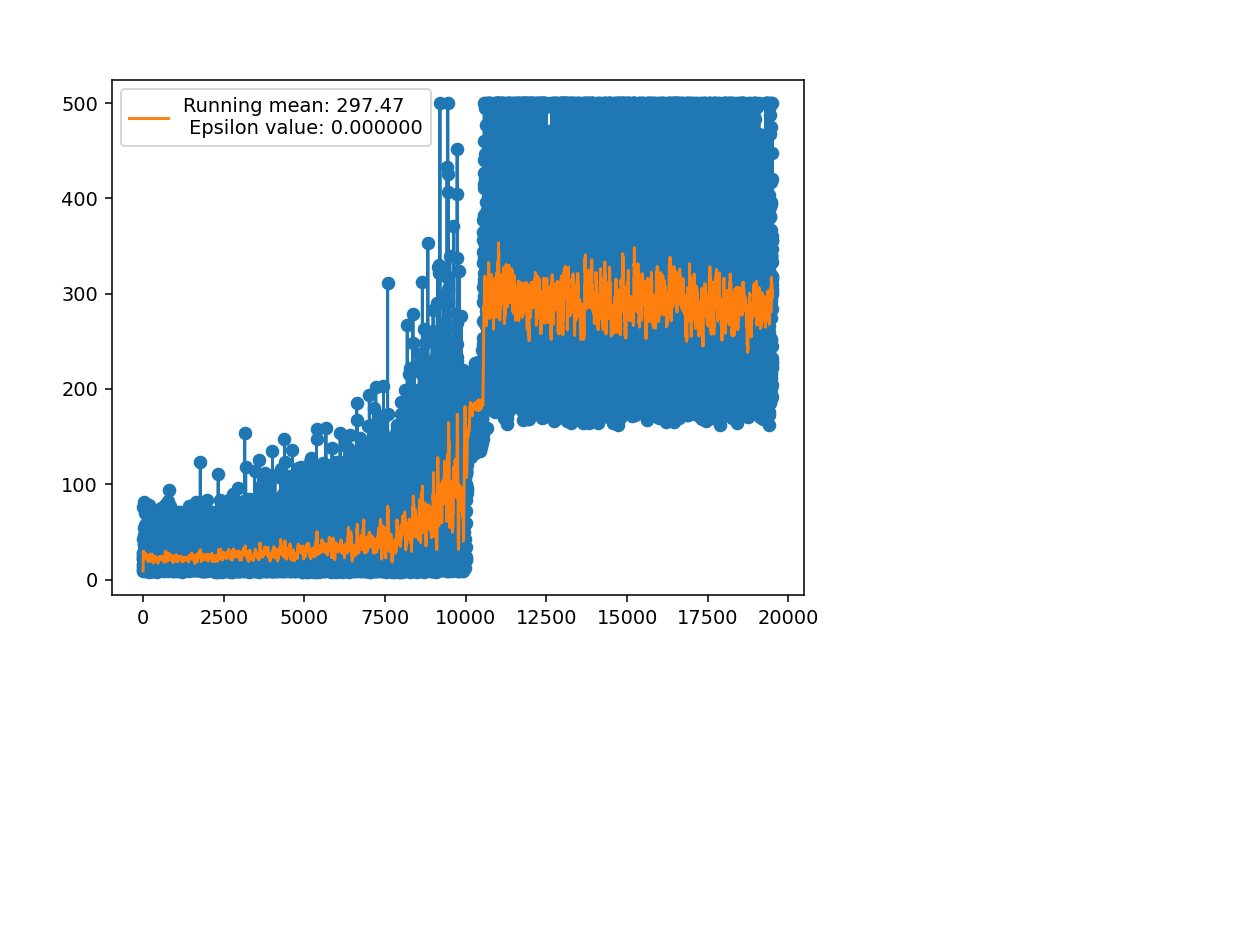

In [23]:
# Visualizzazione del progresso dell'apprendimento

#####################################################

log_interval = 500
render_interval = 2000

fig = plt.figure()
ax = fig.add_subplot(111)
plt.ion()
fig.canvas.draw()

######################################################

points_log = []
mean_points_log = []
epochs = []

"""
EPOCHS = Numero di partite (non numero di mosse/step)
"""

for epoch in range(EPOCHS):
    
    state = env.reset()      # Obbligatorio ad ogni inizio partita
    discretized_state = discretize_observation(state, BINS)
    
    done = False
    points = 0
    
    epochs.append(epoch)
    
    while not done:
        
        action = epsilon_greedy_action_selection(epsilon, q_table, discretized_state)
        new_state, reward, done, info = env.step(action)
        reward = fail(done, points, reward)
        
        new_state_discretized = discretize_observation(new_state, BINS)
        
        #################################################
        
        old_q_value = q_table[discretized_state + (action,)]
        next_optimal_q_value = np.max(q_table[new_state_discretized])
        next_q = compute_next_q_value(old_q_value, reward, next_optimal_q_value)
        q_table[discretized_state + (action,)] = next_q
        
        ##################################################
        
        discretized_state = new_state_discretized
        points += 1
        
    
    epsilon = reduce_epsilon(epsilon, epoch)
    points_log.append(points)
    running_mean= round(np.mean(points_log[-30:]),2)
    mean_points_log.append(running_mean)
    
    ############# Plot the points ################
    
    if epoch % log_interval == 0:
        ax.clear()
        ax.scatter(epochs, points_log)
        ax.plot(epochs, points_log)
        ax.plot(epochs, mean_points_log, label=f"Running mean: {running_mean}\n Epsilon value: {epsilon:02f}")
        plt.legend()
        fig.canvas.draw()
        
    ##############################################

    
env.close()

### Let Agent Play

In [24]:
observation = env.reset()
rewards = 0

for _ in range(1000):
    env.render()
    discretized_state = discretize_observation(observation, BINS)
    
    action = np.argmax(q_table[discretized_state])
    observation, reward, done, info = env.step(action)
    
    rewards += 1
    
    if done:
        print(f"Punteggio raggiunto {rewards}")
        break

env.close()

Punteggio raggiunto 432
